<a href="https://colab.research.google.com/github/JoseFPortoles/Segnet-in-Keras/blob/master/AmpliacionCV_Final_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation Model

## Set Variables

In [16]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import Input

#Variables
x_imsize = 224
y_imsize = 224
img_size = (x_imsize,y_imsize)
n_classes = 22
epochs_model1 = 1
epochs_model2 = 150


###COLAB### voc_root_folder = "/content/VOCdevkit/VOC2009"
voc_root_folder = "./VOCdevkit/VOC2009"
#voc_root_folder = "../input/voc2009/VOCdevkit/VOC2009"

## Fetch data

### VOC 2009 DATASET

#### Fetch Data

In [3]:
#!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar

#Decompress from home directory 
#!tar -xf VOCtrainval_11-May-2009.tar --totals

# Decompress VOC 2009 tar file stored in drive
!tar -xf "./drive/My Drive/VOCtrainval_11-May-2009.tar" $pwd --totals

Total bytes read: 935536640 (893MiB, 45MiB/s)


#### Create directory tree

In [8]:
#%matplotlib inline
#from matplotlib import pyplot as plt
import os, shutil
#import cv2
#import xml.etree.ElementTree as ET

#START PATHS
#base_path = './VOCdevkit/VOC2009'
base_path = voc_root_folder
img_start_path = os.path.join(base_path, 'JPEGImages')
mask_start_path = os.path.join(base_path, 'SegmentationClass')
train_list_path = os.path.join(base_path, 'ImageSets/Segmentation/train.txt')
trainval_list_path = os.path.join(base_path, 'ImageSets/Segmentation/trainval.txt')
val_list_path = os.path.join(base_path, 'ImageSets/Segmentation/val.txt')

print(train_list_path)
print(trainval_list_path)
print(val_list_path)

#END PATHS
train_end_path = './dataset/segmentation/train'
train_mask_end_path = './dataset/segmentation/train_masks'
trainval_end_path = './dataset/segmentation/trainval'
trainval_mask_end_path = './dataset/segmentation/trainval_masks'
val_end_path = './dataset/segmentation/val'
val_mask_end_path = './dataset/segmentation/val_masks'

def copy_segmentation_files(list_path, start_path, end_path):
    #CLEAR/CREATE END FOLDERS
    shutil.rmtree(end_path, ignore_errors=True)
    os.makedirs(end_path, exist_ok=True)
    
    startlist = os.listdir(start_path)
    ext = startlist[0][-4:]
    #READ SEGMENTATION TRAINSET LIST AND COPY FILES
    f = open(list_path, "r")
    for line in f:
        print(str(os.path.isfile(os.path.join(start_path, line[:-1] + ext)))+': '+os.path.join(start_path, line[:-1] + ext))
        if os.path.isfile(os.path.join(start_path, line[:-1] + ext)):
            shutil.copy(os.path.join(start_path, line[:-1] + ext), end_path)
    f.close()
    
#COPY IMAGES AND MASKS FROM START PATHS TO END PATHS
print('Copying segmentation training images\n')
copy_segmentation_files(train_list_path, img_start_path, train_end_path)
print('Copying segmentation training masks\n')
copy_segmentation_files(train_list_path, mask_start_path, train_mask_end_path)
print('Copying segmentation training/validation images\n')
copy_segmentation_files(trainval_list_path, img_start_path, trainval_end_path)
print('Copying segmentation training/validation masks\n')
copy_segmentation_files(trainval_list_path, mask_start_path, trainval_mask_end_path)
print('Copying segmentation validation images\n')
copy_segmentation_files(val_list_path, img_start_path, val_end_path)
print('Copying segmentation validation masks\n')
copy_segmentation_files(val_list_path, mask_start_path, val_mask_end_path)


Se han truncado las últimas 5000 líneas del flujo de salida.
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008403.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008407.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008468.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008526.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008571.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008575.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008714.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008764.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008778.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008801.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008821.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008927.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008932.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008945.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008948.png
True: ./VOCdevkit/VOC2009/SegmentationC

#### Create path lists

In [9]:
train_input_dir = train_end_path
train_target_dir = train_mask_end_path
val_input_dir = val_end_path
val_target_dir = val_mask_end_path

train_input_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".jpg")
    ]
)
train_target_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

val_input_paths = sorted(
    [
        os.path.join(val_input_dir, fname)
        for fname in os.listdir(val_input_dir)
        if fname.endswith(".jpg")
    ]
)
val_target_paths = sorted(
    [
        os.path.join(val_target_dir, fname)
        for fname in os.listdir(val_target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of training samples:", len(train_input_paths),'\n')
print("Number of validation samples:", len(val_input_paths))

for input_path, target_path in zip(train_input_paths[:10], train_target_paths[:10]):
    print(input_path, "|", target_path)

Number of training samples: 749 

Number of validation samples: 750
./dataset/segmentation/train/2007_000032.jpg | ./dataset/segmentation/train_masks/2007_000032.png
./dataset/segmentation/train/2007_000039.jpg | ./dataset/segmentation/train_masks/2007_000039.png
./dataset/segmentation/train/2007_000063.jpg | ./dataset/segmentation/train_masks/2007_000063.png
./dataset/segmentation/train/2007_000068.jpg | ./dataset/segmentation/train_masks/2007_000068.png
./dataset/segmentation/train/2007_000121.jpg | ./dataset/segmentation/train_masks/2007_000121.png
./dataset/segmentation/train/2007_000170.jpg | ./dataset/segmentation/train_masks/2007_000170.png
./dataset/segmentation/train/2007_000241.jpg | ./dataset/segmentation/train_masks/2007_000241.png
./dataset/segmentation/train/2007_000243.jpg | ./dataset/segmentation/train_masks/2007_000243.png
./dataset/segmentation/train/2007_000250.jpg | ./dataset/segmentation/train_masks/2007_000250.png
./dataset/segmentation/train/2007_000256.jpg | ./d

In [7]:
#Sanity check
print('Nr of train images: ' + str(len(os.listdir(train_end_path))) + '\n')
print('Nr of train masks: ' + str(len(os.listdir(train_mask_end_path))) + '\n')
print('Nr of train/validation images: ' + str(len(os.listdir(trainval_end_path))) + '\n')
print('Nr of train/validation masks: ' + str(len(os.listdir(trainval_mask_end_path))) + '\n')
print('Nr of validation images: ' + str(len(os.listdir(val_end_path))) + '\n')
print('Nr of validation masks: ' + str(len(os.listdir(val_mask_end_path))) + '\n')

Nr of train images: 749

Nr of train masks: 749

Nr of train/validation images: 1499

Nr of train/validation masks: 1499

Nr of validation images: 750

Nr of validation masks: 750



## Model 2: VGG-16 with Imagenet weights on a SegNet architecture

### VGG-16 with ImageNet pretrained weights

In [10]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(x_imsize,y_imsize,3))

#Freeze convolutional base
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Architecture: Segnet(VGG16) without recycling maxpooling indices
I implemented this as an encoder-decoder structure, with the decoder built as a symmetrical stack of layers respect to VGG16 and connected to the output of VGG16 to form the complete model. Beware that this does not follow the full specification of SegNet. In SegNet the indices used by the maxpooling layers in the encoder half of the model are passed to the corresponding upsampling layers in the decoder in order to be used in the upsampling operation. This is in order to avoid information loss regarding the images fine detail. Standard keras layers don't allow reuse of maxpooling indices in such a way. If I had more time I would define custom maxpooling and upsampling layers to allow for indices reuse.

In [11]:
kernel = (3,3)

decoding_layers = [
    #Block5_mirror
    #UpSampling2D(), 
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel,  padding='same'),
    BatchNormalization(),
    Activation('relu'),

    #Block4_mirror
    UpSampling2D(),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    #Block3_mirror
    UpSampling2D(),
    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    #Block2_mirror
    UpSampling2D(),
    Conv2D(128, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    #Block1_mirror
    UpSampling2D(),
    Conv2D(64, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    UpSampling2D(),
    Conv2D(n_classes, 1, 1, padding='same'),
    BatchNormalization(),
    Activation('softmax')
]

model = models.Sequential()
model.add(conv_base)

for layer in decoding_layers:
  model.add(layer)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 512)         2359808   
_________________________________________________________________
batch_normalization_14 (Batc (None, 7, 7, 512)         2048      
_________________________________________________________________
activation_14 (Activation)   (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 512)         2359808   
_________________________________________________________________
batch_normalization_15 (Batc (None, 7, 7, 512)         2048      
_________________________________________________________________
activation_15 (Activation)   (None, 7, 7, 512)        

### Load a saved model:
Uncomment if loading of a pre-saved model is needed at this point.

In [ ]:
from tensorflow import keras
#model_path = './voc2009_segmentation.h5'
model_path ='/content/drive/My Drive/VOCSegment_ImageNetVGG16_22cat_100epochs(colab).h5'
model = keras.models.load_model(model_path)

## DATA GENERATION



### Data generator class
Here I use the Sequence class from Keras instead of ImageDataGenerator. This is in order to produce customised masks that allow to:
* Either work with the 20 original Pascal-VOC-2009 object categories or to define broader categories. This is done through a for-loop that goes through each pixel of the original mask modifying the values of selected categories. 
* Ensure that the pixel value for the border regions is a consecutive integer to the object categories.
* Produce one-hot-encoding masks to be used during training with in conjunction with the categorical crossentropy loss function. 
* Resize the mask to fit the dimensions of the model's output, in case the model happened to change the resolution of the input images.

The main disadvantage of this approach is perhaps having to implement data augmentation, as it is not built in the Sequence class. This would be my next step should I have more time. I would probably use a preexisting dedicated library such as albumentations (https://github.com/albumentations-team/albumentations) or imgaug (https://github.com/aleju/imgaug)



#### 20 VOC-2009 Categories
This data generator generates masks with the original values with the exception of border pixels (value = 255) that are converted to 21 and so counted as an extra category. Therefore:
  * 0: Background pixels
  * 1-20: VOC 2009 object categories
  * 21: Border regions

In [12]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage
from tensorflow import keras
import numpy as np
import PIL
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class VOC2009SegData(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, num_classes, img_size, mask_size, input_img_paths, target_img_paths, augmentation=False):
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.img_size = img_size
        self.mask_size = mask_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.seq = iaa.Sequential(
            [
             iaa.Fliplr(0.5),  
             iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
             iaa.ContrastNormalization((0.75, 1.5)),
             iaa.AdditiveGaussianNoise(
                 loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
             iaa.Multiply((0.8, 1.2), per_channel=0.2),
             iaa.Affine(
                 scale={
                     "x": (0.8, 1.2),
                     "y": (0.8, 1.2)
                },
                translate_percent={
                    "x": (-0.2, 0.2),
                    "y": (-0.2, 0.2)
                },
                rotate=(-25, 25),
                shear=(-8, 8)
                )
             ],
             random_order=True)
        self.augmentation = augmentation

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) corresponding to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((batch_size,) + self.mask_size + (self.num_classes,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            msk = PIL.Image.open(path)
            msk = msk.resize(self.mask_size, resample=PIL.Image.NEAREST)
            msk = np.array(msk,dtype="uint8")
            msk = np.where(msk==255, 21, msk)
            
            # One-hot encoding
            msk = to_categorical(msk, num_classes=self.num_classes)
            
            # Augmentation
            if self.augmentation:
              msk = SegmentationMapOnImage(msk, shape=x[j].shape)
              aug_img, aug_msk = self.seq(image=x[j], segmentation_maps=msk)
              x[j] = aug_img
              y[j] = aug_msk.arr 
            else:
              y[j] = msk
        return x, y

# Define data and mask sizes

img_size = (x_imsize, y_imsize)
batch_size = 32
#Shape of the model output (to resize mask to size)
mask_size = tuple(model.layers[-1].output.shape[1:3])

# Instantiate data Sequences for each split

train_gen = VOC2009SegData(
    batch_size, n_classes, img_size, mask_size, train_input_paths, train_target_paths, augmentation=True
)
val_gen = VOC2009SegData(batch_size, n_classes, img_size, mask_size, val_input_paths, val_target_paths, augmentation=False)


## TRAIN MODEL 2

In [23]:
# Configure the model for training.
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import CategoricalCrossentropy

model.compile(optimizer=optimizers.RMSprop(lr=5e-3, momentum=0.9), loss="categorical_crossentropy", metrics=[MeanIoU(num_classes=n_classes)])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "/content/drive/My Drive/data/ampliacion_segmentation.h5",
        monitor = 'val_loss',
        save_best_only=True,
        ),
    #keras.callbacks.EarlyStopping(
    #    monitor = 'val_loss',
    #   patience = 10,
    #)
]

# Train the model, doing validation at the end of each epoch.
epochs = epochs_model2
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/150
23/23 [==============================] - 65s 3s/step - loss: 1.0882 - mean_io_u_6: 0.4832 - val_loss: 16.0304 - val_mean_io_u_6: 0.4561
Epoch 2/150
23/23 [==============================] - 65s 3s/step - loss: 0.9346 - mean_io_u_6: 0.4832 - val_loss: 13.9151 - val_mean_io_u_6: 0.4968
Epoch 3/150
23/23 [==============================] - 61s 3s/step - loss: 0.9005 - mean_io_u_6: 0.4833 - val_loss: 14.3242 - val_mean_io_u_6: 0.4829
Epoch 4/150
23/23 [==============================] - 61s 3s/step - loss: 0.8795 - mean_io_u_6: 0.4832 - val_loss: 14.7087 - val_mean_io_u_6: 0.4686
Epoch 5/150
23/23 [==============================] - 65s 3s/step - loss: 0.8592 - mean_io_u_6: 0.4833 - val_loss: 12.5209 - val_mean_io_u_6: 0.4774
Epoch 6/150
23/23 [==============================] - 65s 3s/step - loss: 0.8408 - mean_io_u_6: 0.4832 - val_loss: 9.3460 - val_mean_io_u_6: 0.4785
Epoch 7/150
23/23 [==============================] - 64s 3s/step - loss: 0.8417 - mean_io_u_6: 0.4833 - val_loss:

KeyboardInterrupt: ignored

## VISUALISE PREDICTIONS MODEL2
This part simply makes a prediction on the dataset and displays a batch of them: For each picture it displays the original picture followed by ground truth mask and that followed by predicted mask. It also prints a list of the object categories found on the ground truth followed by the same list for the predicted masks.

In [20]:
#VOC 2009
test_gen = VOC2009SegData(5, n_classes, img_size, mask_size, val_input_paths, val_target_paths)
x = test_gen.__getitem__(0)
test_predicts = model.predict([x[0]])

In [21]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
#mask = np.array([[3,4],[5,0]], dtype='uint8')

def disp_mask(img_array):
  flatmask = np.argmax(img_array, axis=2)
  print(np.unique(flatmask))
  plt.figure(figsize=(5, 5))
  plt.imshow(flatmask)
  plt.axis('off')
  plt.show()


[ 0  1 21]


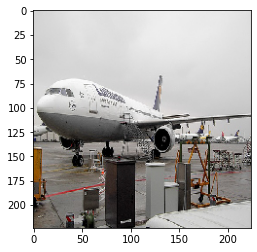

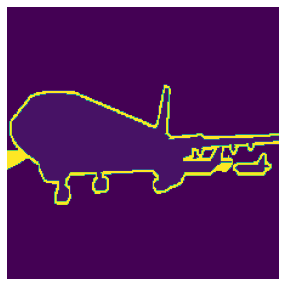

[0 1]


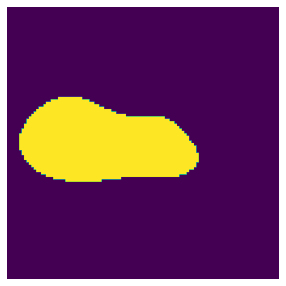

[ 0 19 21]


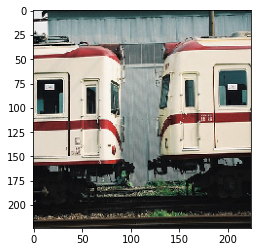

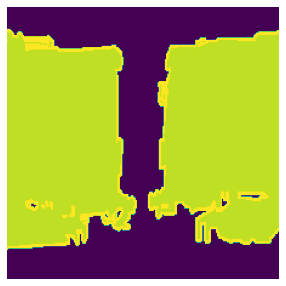

[ 0 19]


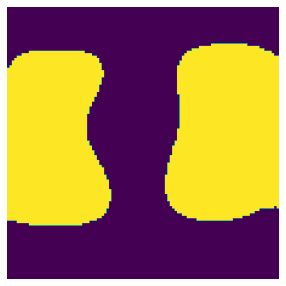

[ 0  4 21]


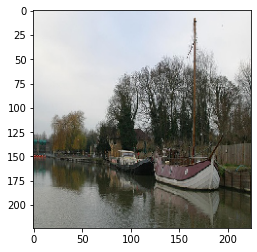

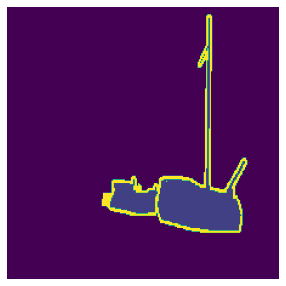

[0 4]


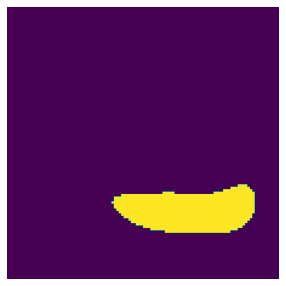

[ 0 19 21]


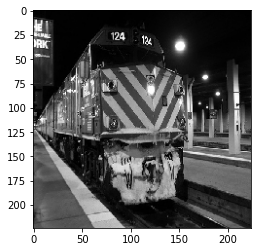

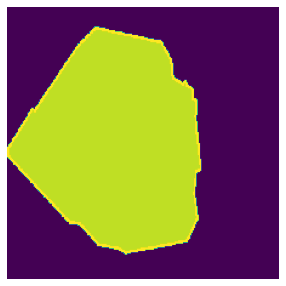

[ 0 19]


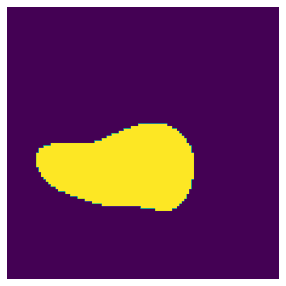

[ 0  2 15 21]


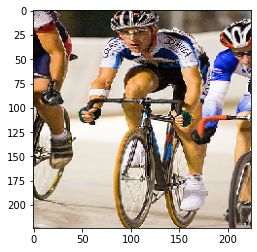

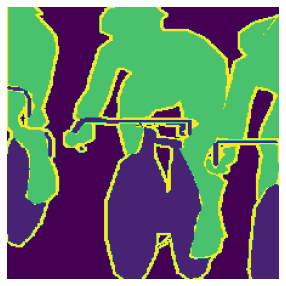

[ 0  2  5 15 21]


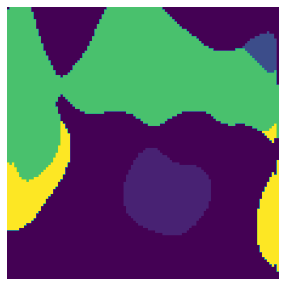

[ 0 17 21]


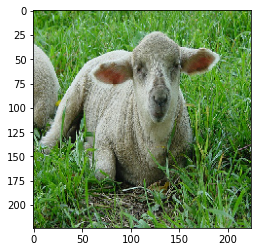

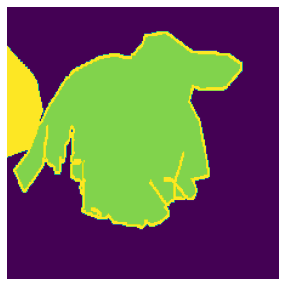

[ 0 10 17 21]


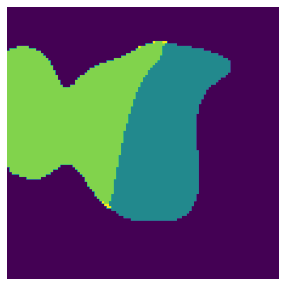

[ 0 20 21]


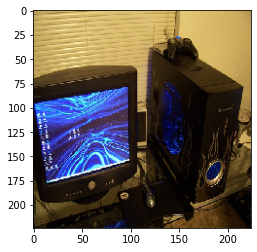

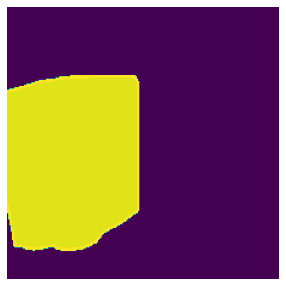

[ 0 20]


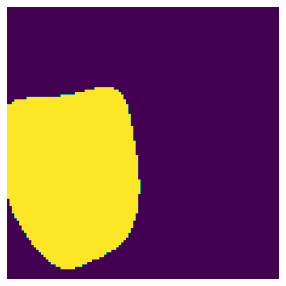

[ 0 15 21]


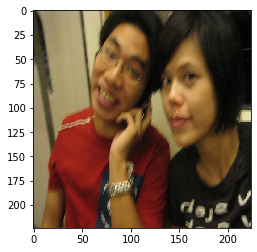

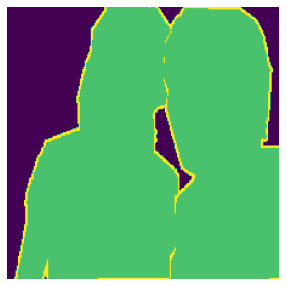

[ 0 15]


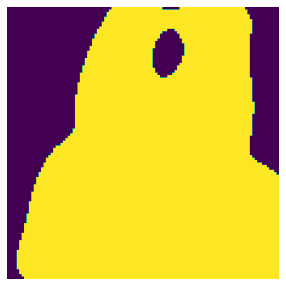

[ 0 13 21]


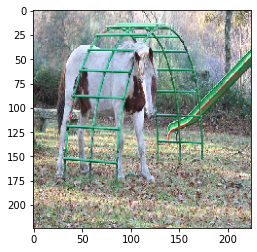

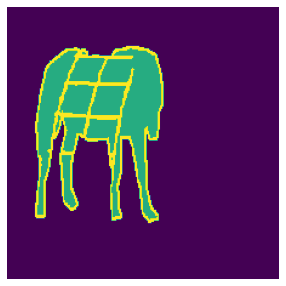

[ 0 13 15]


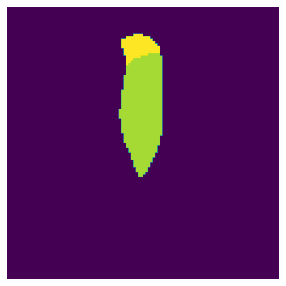

[ 0  5 15 21]


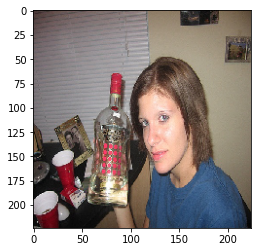

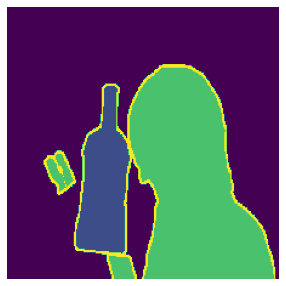

[ 0  5 15 21]


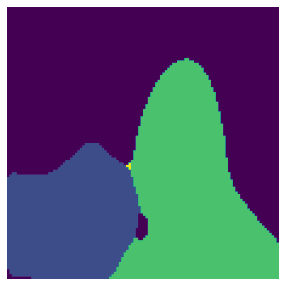

[ 0  9 18 21]


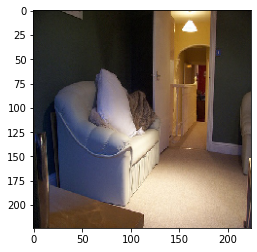

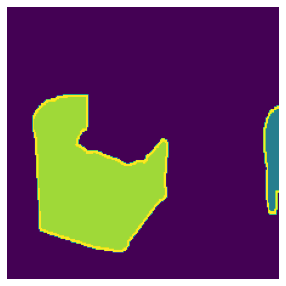

[ 0  9 11]


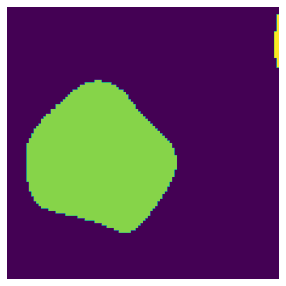

[ 0 10 21]


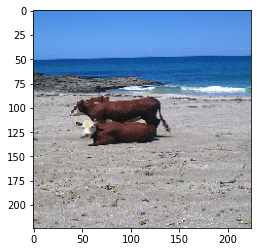

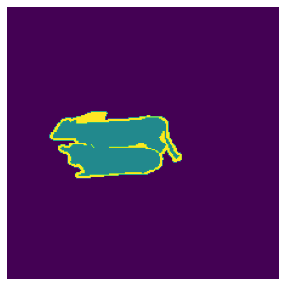

[ 0 10]


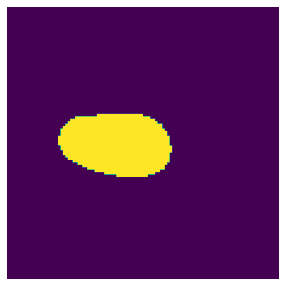

[ 0 10 21]


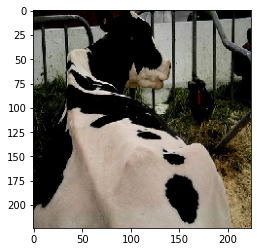

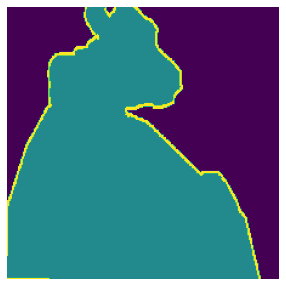

[ 0 10 15 21]


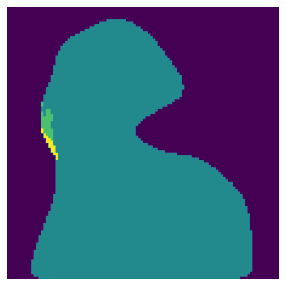

[ 0  4  7 21]


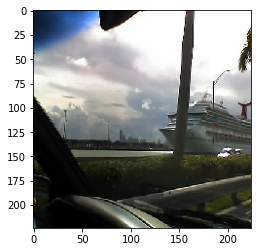

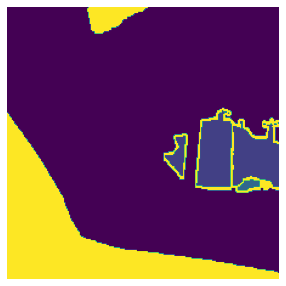

[0 1 3 4]


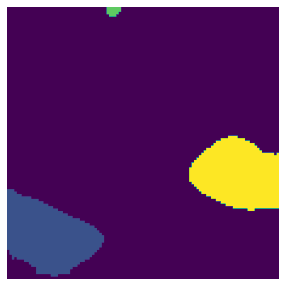

[ 0  5 20 21]


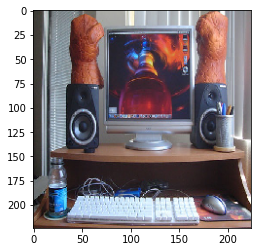

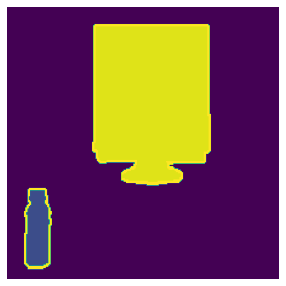

[ 0  8 11 15 20]


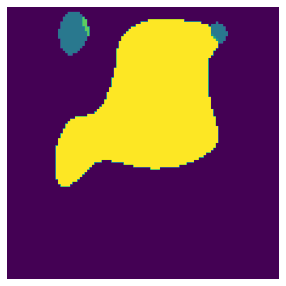

[ 0  2 21]


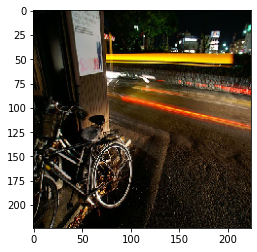

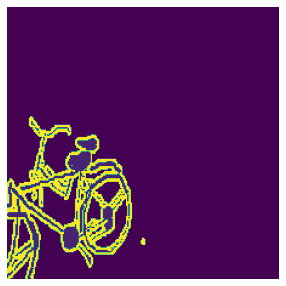

[ 0 19]


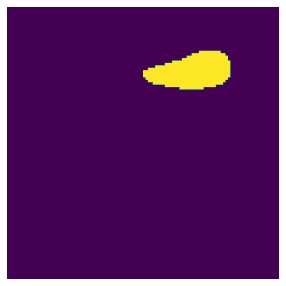

[ 0 15 19 21]


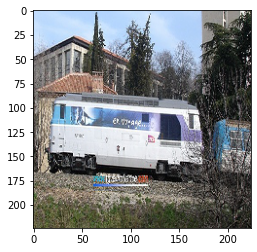

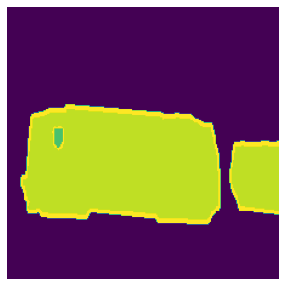

[ 0  6 19 21]


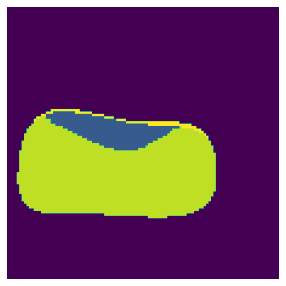

[ 0 19 21]


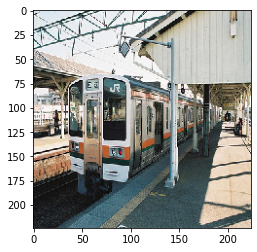

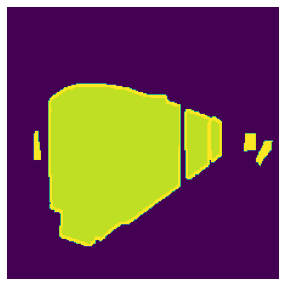

[ 0 19]


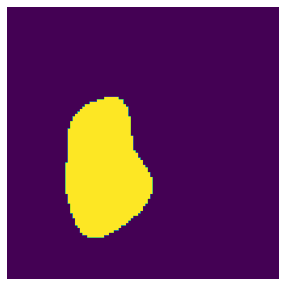

[ 0  9 16 18 21]


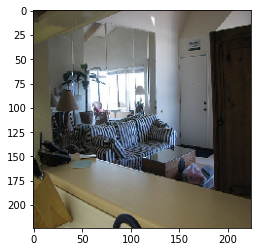

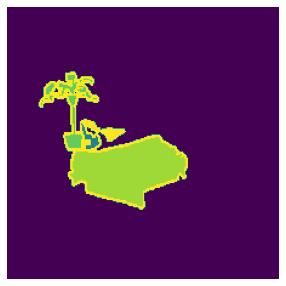

[0]


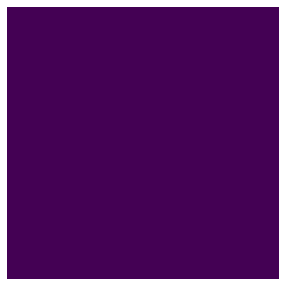

[ 0  6  7 21]


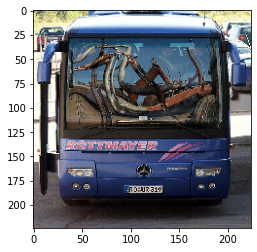

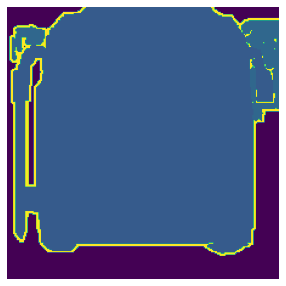

[ 0  6 19 20 21]


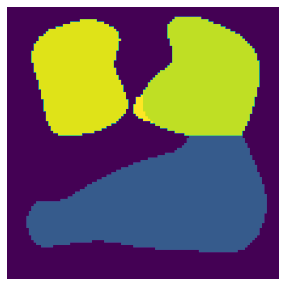

[ 0 17 21]


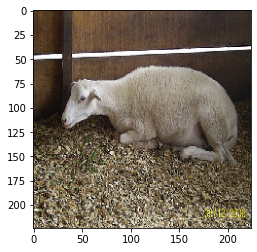

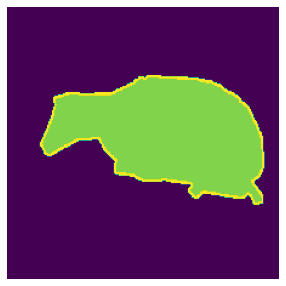

[ 0  9 16 17]


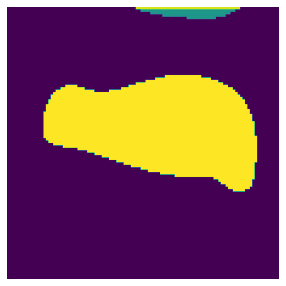

[ 0  6  7 15 21]


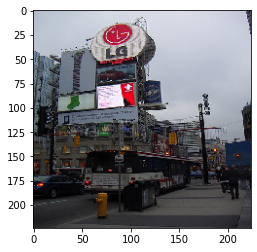

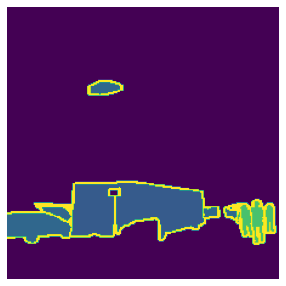

[ 0  4  6 19]


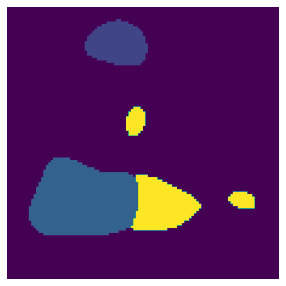

[ 0  5 11 15 21]


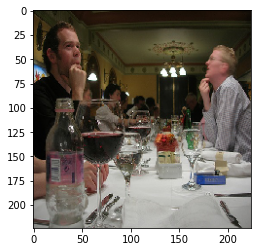

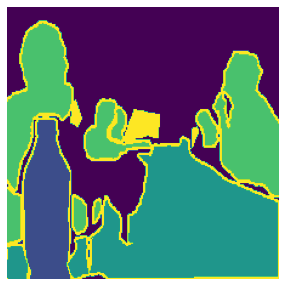

[ 0  5 11 15 21]


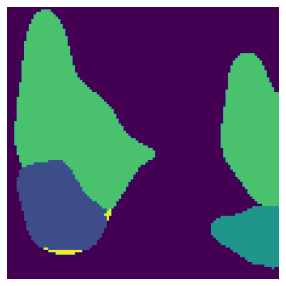

[ 0 13 15 21]


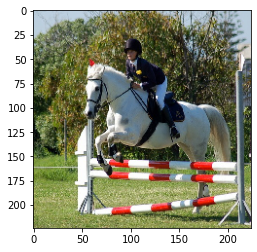

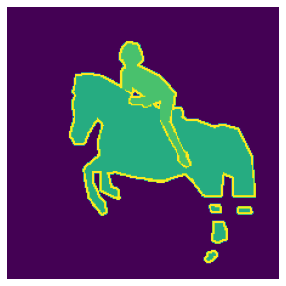

[ 0 13 15 21]


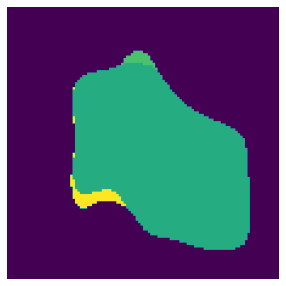

[ 0 13 15 21]


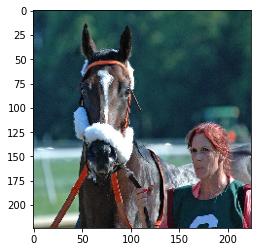

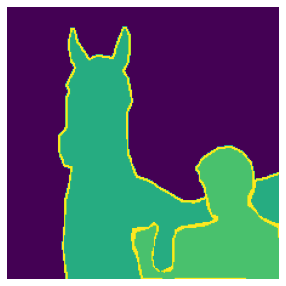

[ 0 13 15 21]


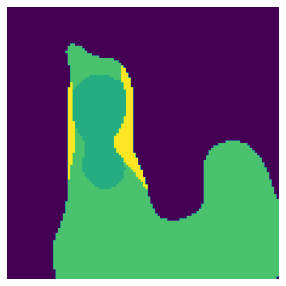

[ 0  9 18 21]


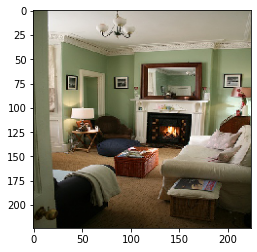

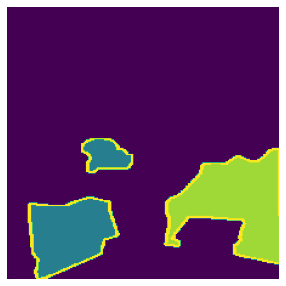

[ 0  9 18]


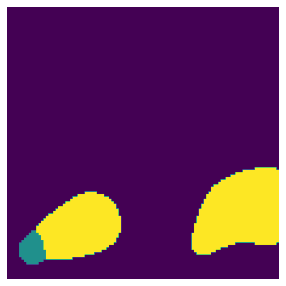

[ 0  9 11 21]


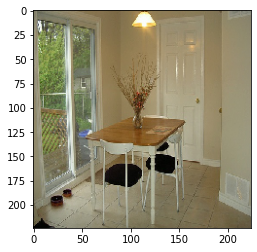

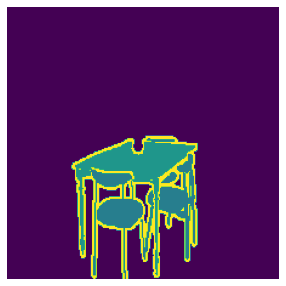

[0]


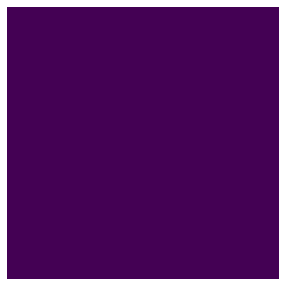

[ 0  4 21]


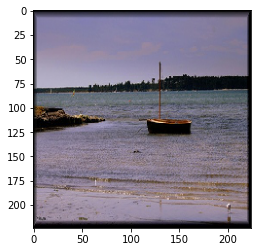

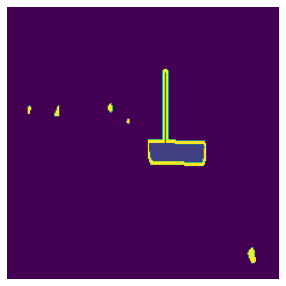

[0 4]


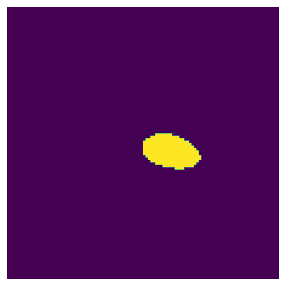

[ 0 11 15 21]


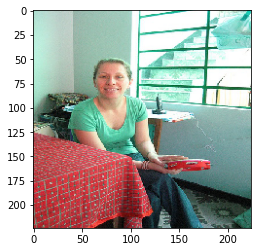

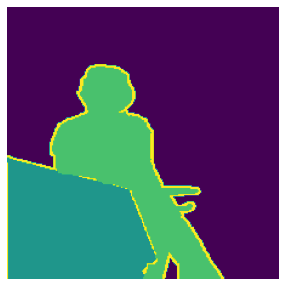

[ 0 15]


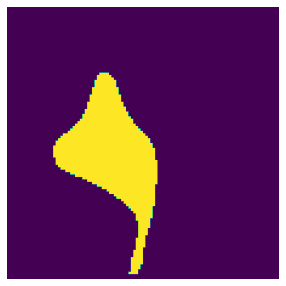

[ 0  4 15 21]


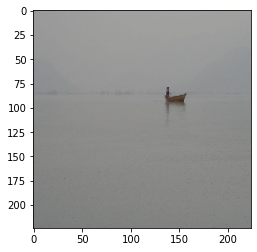

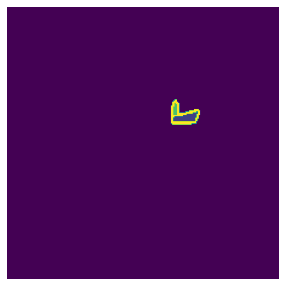

[0 4]


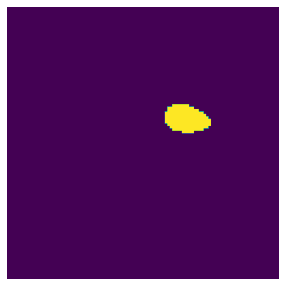

[ 0 17 21]


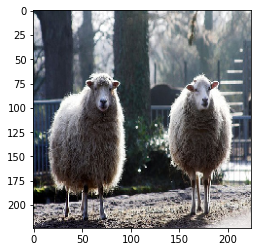

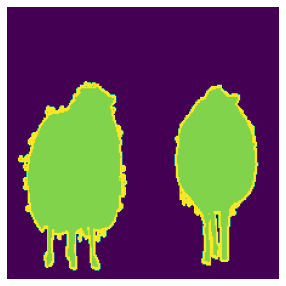

[ 0 17]


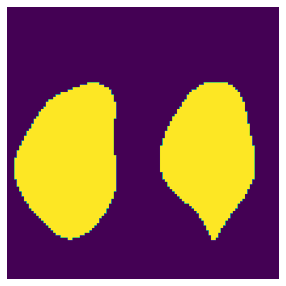

In [22]:
data_batch = val_gen.__getitem__(0)
image_batch = data_batch[0].astype(np.uint8)
mask_batch = data_batch[1]
est_predicts = model.predict(data_batch)
for n in range(0,31):
  plt.imshow(image_batch[n])
  disp_mask(mask_batch[n])
  disp_mask(est_predicts[n])
